In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import utils
from importlib import reload
from torchinfo import summary

In [16]:
# CNN 前半部分のレイヤー関数の確認
conv1 = nn.Conv2d(3, 32, 3)
relu = nn.ReLU()
conv2 = nn.Conv2d(32, 32, 3)
maxpool1 = nn.MaxPool2d(2, 2)

In [17]:
print(conv1)

print(conv1.weight.shape)
print(conv1.bias.shape)

print(conv2.weight.shape)
print(conv2.bias.shape)

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])


In [18]:
# 畳み込み処理とプーリング処理のシミュレーション
inputs = torch.rand(100, 3, 32, 32)
print(inputs.shape)

# CNNの前半部分のシミュレーション
x1 = conv1(inputs)
x2 = relu(x1)
x3 = conv2(x2)
x4 = relu(x3)
x5 = maxpool1(x4)

print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x4.shape)
print(x5.shape)

torch.Size([100, 3, 32, 32])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 14, 14])


In [20]:
# Sequentialを使ったCNNの前半部分のシミュレーション
features = nn.Sequential(
    conv1,
    relu,
    conv2,
    relu,
    maxpool1
)

outputs = features(inputs)
print(outputs.shape)

torch.Size([100, 32, 14, 14])


In [21]:
# flatten()の確認
flatten = nn.Flatten()

outputs2 = flatten(outputs)

print(outputs.shape)
print(outputs2.shape)

torch.Size([100, 32, 14, 14])
torch.Size([100, 6272])


In [7]:
# Transforms の定義
# 1つ目は全結合層用なので，flatten() で1次元に変換する
transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1))
])

# 2つ目はCNN用
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

In [8]:
# データセット
data_root = '../data'

train_set1 = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=transform1
)

test_set1 = datasets.CIFAR10(
    root=data_root,
    train=False,
    download=True,
    transform=transform1
)

train_set2 = datasets.CIFAR10(
    root=data_root,
    train=True,
    download=True,
    transform=transform2
)

test_set2 = datasets.CIFAR10(
    root=data_root,
    train=False,
    download=False,
    transform=transform2
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [9]:
image1, label1 = train_set1[0]
image2, label2 = train_set2[0]
print(image1.shape)
print(image2.shape)

torch.Size([3072])
torch.Size([3, 32, 32])


In [13]:
# データローダ
# ミニバッチ
batch_size = 100

# 訓練データ
# 訓練データにはシャッフルを行う
train_loader1 = DataLoader(train_set1, batch_size=batch_size, shuffle=True)

# テストデータ
test_loader1 = DataLoader(test_set1, batch_size=batch_size, shuffle=False)

# 訓練データ
# 訓練データにはシャッフルを行う
train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)

# テストデータ
test_loader2 = DataLoader(test_set2, batch_size=batch_size, shuffle=False)

In [14]:
for image1, label1 in train_loader1:
    break

for image2, label2 in train_loader2:
    break

print(image1.shape)
print(image2.shape)

torch.Size([100, 3072])
torch.Size([100, 3, 32, 32])


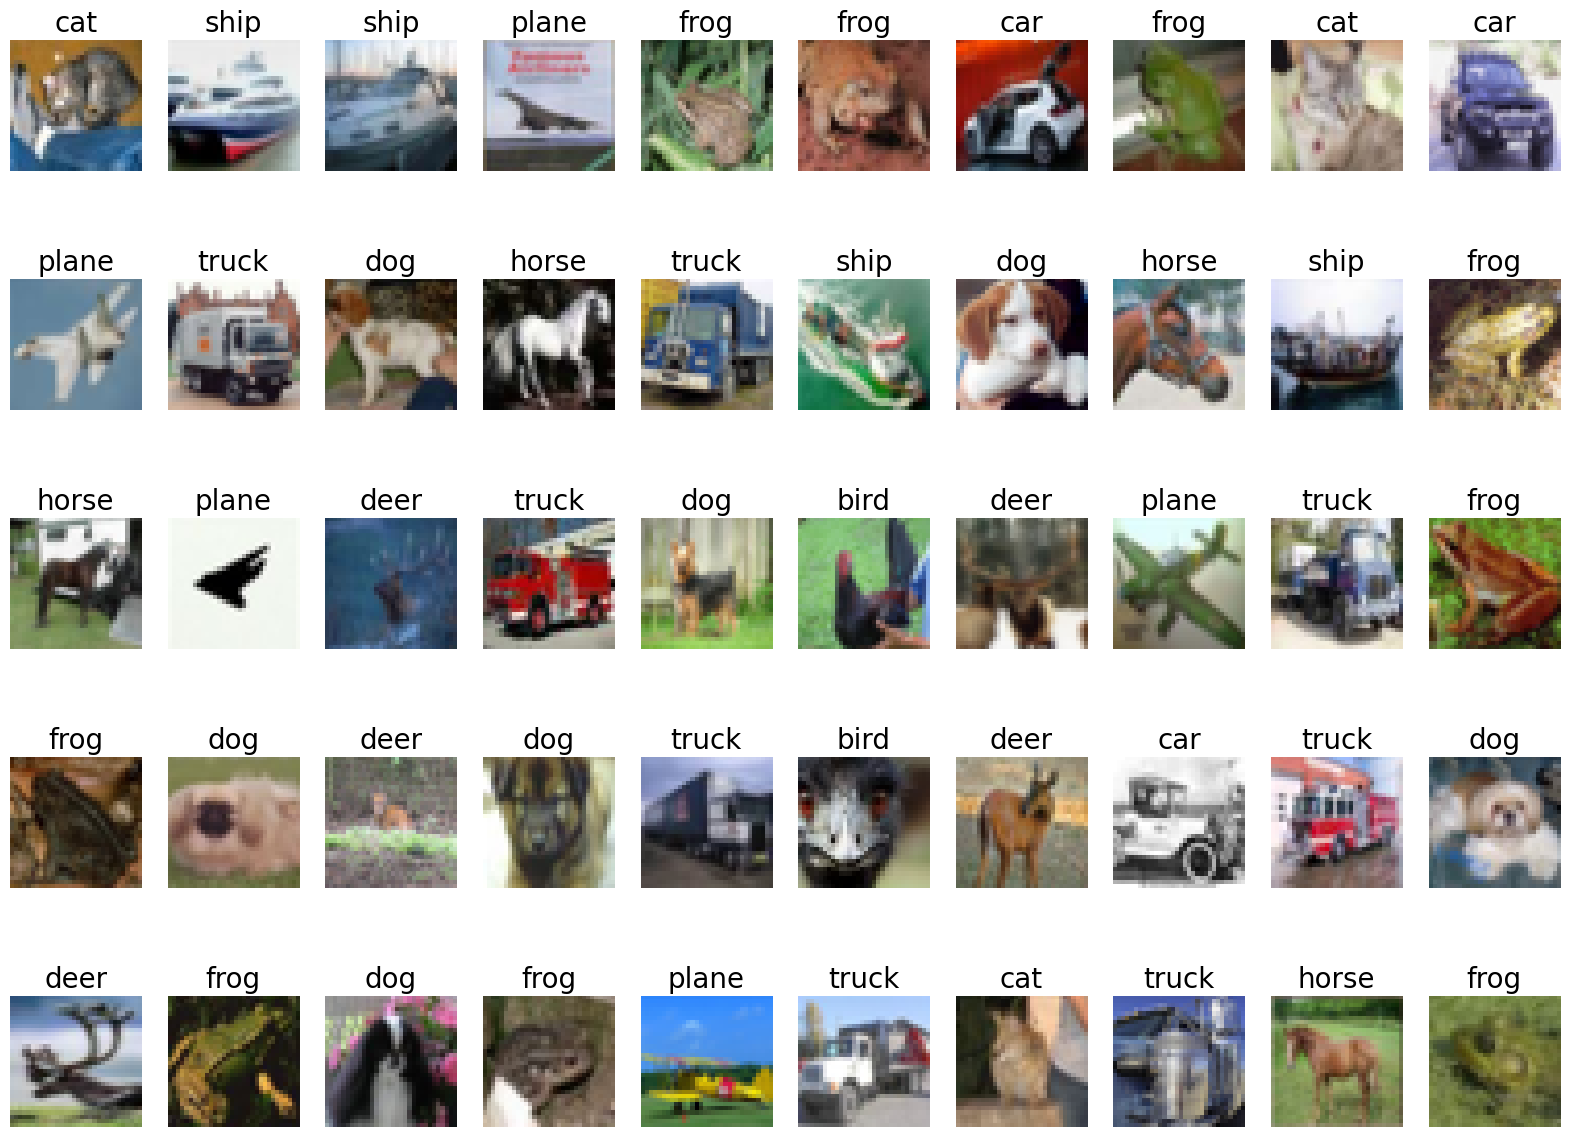

In [22]:
# 検証データのイメージ表示
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
utils.show_images_labels(test_loader2, classes, None, None)

In [40]:
# モデル定義（全結合層）
# 今回は全結合層とCNNの精度を比較する
n_input = 3072  # 32x32x3

n_output = len(classes)

n_hidden = 128

print(f'n_input: {n_input}, n_output: {n_output}, n_hidden: {n_hidden}')

n_input: 3072, n_output: 10, n_hidden: 128


In [41]:
class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        self.l1 = nn.Linear(n_input, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_output)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

In [44]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = Net(n_input, n_output, n_hidden).to(device)

lr = 0.01

optimizer = optim.SGD(net.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

num_epochs = 50

history = np.zeros((0, 5))

utils.torch_seed()

reload(utils)

history = utils.fit(net, optimizer, criterion , num_epochs, train_loader1, test_loader1, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 1.95170 acc: 0.32110 val_loss: 1.79986, val_acc: 0.37340


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.74168 acc: 0.39318 val_loss: 1.68769, val_acc: 0.41390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 1.65712 acc: 0.42428 val_loss: 1.62682, val_acc: 0.43500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 1.60260 acc: 0.44414 val_loss: 1.58437, val_acc: 0.45160


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 1.56268 acc: 0.45734 val_loss: 1.55396, val_acc: 0.46310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 1.53010 acc: 0.46922 val_loss: 1.53401, val_acc: 0.46940


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 1.50236 acc: 0.47962 val_loss: 1.51630, val_acc: 0.46820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 1.47825 acc: 0.48770 val_loss: 1.49793, val_acc: 0.48120


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 1.45501 acc: 0.49618 val_loss: 1.48099, val_acc: 0.48630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 1.43418 acc: 0.50542 val_loss: 1.46651, val_acc: 0.48860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 1.41409 acc: 0.51224 val_loss: 1.45585, val_acc: 0.49080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 1.39501 acc: 0.51928 val_loss: 1.44164, val_acc: 0.49360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 1.37678 acc: 0.52420 val_loss: 1.43140, val_acc: 0.50540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 1.35996 acc: 0.53158 val_loss: 1.42061, val_acc: 0.50600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 1.34299 acc: 0.53770 val_loss: 1.41727, val_acc: 0.50440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 1.32821 acc: 0.54300 val_loss: 1.40715, val_acc: 0.50790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 1.31314 acc: 0.54698 val_loss: 1.40275, val_acc: 0.51100


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 1.29881 acc: 0.55240 val_loss: 1.39604, val_acc: 0.51090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 1.28519 acc: 0.55784 val_loss: 1.38612, val_acc: 0.51190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 1.27209 acc: 0.56150 val_loss: 1.38123, val_acc: 0.51270


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 1.25938 acc: 0.56558 val_loss: 1.38674, val_acc: 0.51470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 1.24631 acc: 0.57128 val_loss: 1.37566, val_acc: 0.52040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 1.23389 acc: 0.57404 val_loss: 1.37464, val_acc: 0.51800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 1.22193 acc: 0.58078 val_loss: 1.36734, val_acc: 0.52310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 1.21055 acc: 0.58522 val_loss: 1.36453, val_acc: 0.52210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 1.19912 acc: 0.58836 val_loss: 1.36224, val_acc: 0.52270


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 1.18743 acc: 0.59382 val_loss: 1.35788, val_acc: 0.52330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 1.17717 acc: 0.59684 val_loss: 1.35586, val_acc: 0.52410


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 1.16599 acc: 0.60120 val_loss: 1.34942, val_acc: 0.52890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 1.15540 acc: 0.60510 val_loss: 1.35305, val_acc: 0.52460


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 1.14500 acc: 0.60748 val_loss: 1.34927, val_acc: 0.52530


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 1.13551 acc: 0.61416 val_loss: 1.34893, val_acc: 0.52940


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 1.12511 acc: 0.61570 val_loss: 1.35061, val_acc: 0.52620


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 1.11538 acc: 0.62010 val_loss: 1.35308, val_acc: 0.52560


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 1.10633 acc: 0.62270 val_loss: 1.34539, val_acc: 0.53050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 1.09645 acc: 0.62622 val_loss: 1.34628, val_acc: 0.52890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 1.08672 acc: 0.62884 val_loss: 1.34886, val_acc: 0.52310


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 1.07820 acc: 0.63234 val_loss: 1.34713, val_acc: 0.52780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 1.06912 acc: 0.63724 val_loss: 1.34888, val_acc: 0.52910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 1.05978 acc: 0.64034 val_loss: 1.35329, val_acc: 0.52660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 1.05221 acc: 0.64388 val_loss: 1.34720, val_acc: 0.53110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 1.04277 acc: 0.64696 val_loss: 1.35653, val_acc: 0.52660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 1.03373 acc: 0.64840 val_loss: 1.35270, val_acc: 0.52880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 1.02635 acc: 0.65274 val_loss: 1.35219, val_acc: 0.52650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 1.01779 acc: 0.65434 val_loss: 1.35336, val_acc: 0.52860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 1.01057 acc: 0.65844 val_loss: 1.35247, val_acc: 0.52790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 1.00178 acc: 0.66086 val_loss: 1.35953, val_acc: 0.52720


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.99444 acc: 0.66452 val_loss: 1.36039, val_acc: 0.52650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.98714 acc: 0.66610 val_loss: 1.35673, val_acc: 0.53150


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.97930 acc: 0.66736 val_loss: 1.36421, val_acc: 0.52600


初期状態: 損失: 1.79986 精度: 0.37340
最終状態: 損失: 1.36421 精度: 0.52600


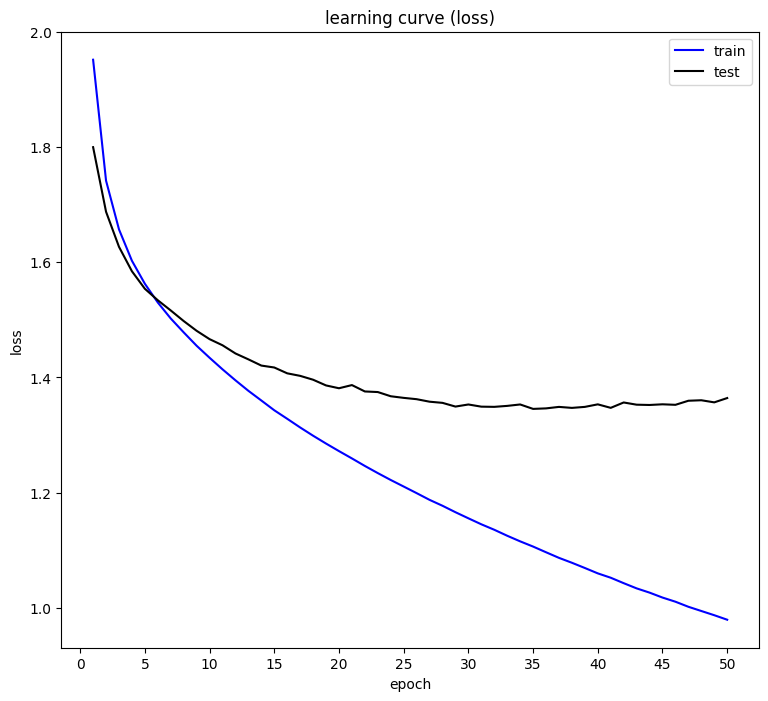

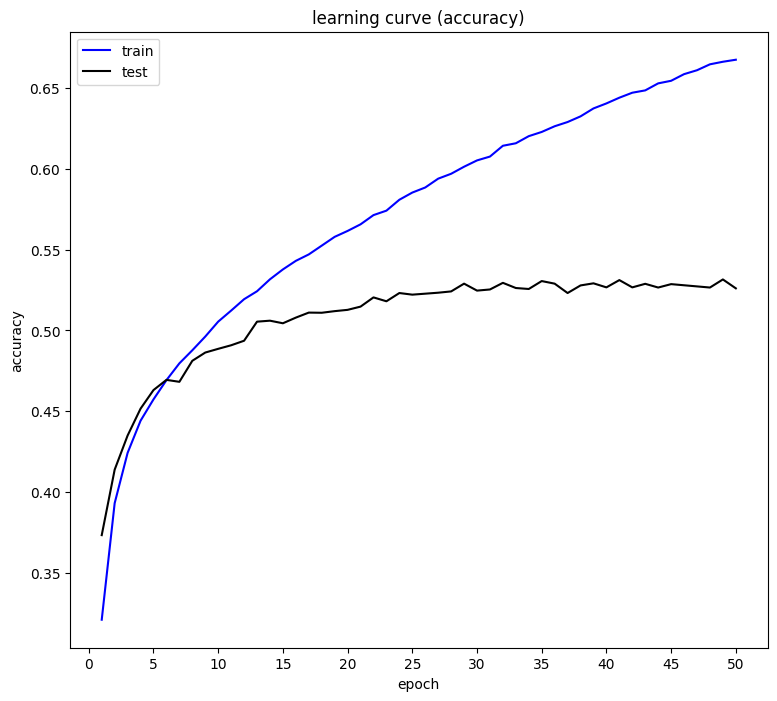

In [47]:
# 精度評価
utils.evaluated_history(history)

In [48]:
class CNN(nn.Module):
    def __init__(self, n_output, n_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d((2, 2))
        self.flatten = nn.Flatten()
        self.l1 = nn.Linear(6272, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_output)
        
        self.features = nn.Sequential(
            self.conv1,
            self.relu,
            self.conv2,
            self.relu,
            self.maxpool
        )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [49]:
print(CNN(n_output, n_hidden))

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=6272, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [51]:
summary(CNN(n_output, n_hidden), (100, 3, 32, 32), depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [100, 10]                 --
├─Sequential: 1-1                        [100, 32, 14, 14]         10,144
├─Sequential: 1-4                        --                        (recursive)
├─Sequential: 1-5                        --                        (recursive)
├─Sequential: 1-4                        --                        (recursive)
├─Sequential: 1-5                        --                        (recursive)
├─Sequential: 1-6                        [100, 10]                 804,234
Total params: 823,626
Trainable params: 823,626
Non-trainable params: 0
Total mult-adds (M): 886.11
Input size (MB): 1.23
Forward/backward pass size (MB): 43.22
Params size (MB): 3.26
Estimated Total Size (MB): 47.71

In [55]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = CNN(n_output, n_hidden).to(device)

lr = 0.01

optimizer = optim.SGD(net.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

num_epochs = 50

history2 = np.zeros((0, 5))

utils.torch_seed()

reload(utils)

history2 = utils.fit(net, optimizer, criterion , num_epochs, train_loader2, test_loader2, device, history2)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 2.08698 acc: 0.26108 val_loss: 1.85100, val_acc: 0.34920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 1.76325 acc: 0.37744 val_loss: 1.66883, val_acc: 0.40610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 1.58697 acc: 0.43758 val_loss: 1.50021, val_acc: 0.46070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 1.46488 acc: 0.47624 val_loss: 1.46578, val_acc: 0.47600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 1.38698 acc: 0.50530 val_loss: 1.35415, val_acc: 0.51240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 1.31942 acc: 0.53070 val_loss: 1.32925, val_acc: 0.52250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 1.25883 acc: 0.55154 val_loss: 1.27278, val_acc: 0.53840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 1.20513 acc: 0.57258 val_loss: 1.22684, val_acc: 0.56130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 1.15970 acc: 0.58812 val_loss: 1.18556, val_acc: 0.57620


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 1.11612 acc: 0.60634 val_loss: 1.17633, val_acc: 0.58060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 1.07352 acc: 0.62144 val_loss: 1.12751, val_acc: 0.60220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 1.03490 acc: 0.63716 val_loss: 1.10888, val_acc: 0.60340


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.99375 acc: 0.65172 val_loss: 1.08527, val_acc: 0.62320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.95614 acc: 0.66606 val_loss: 1.05622, val_acc: 0.63140


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.91912 acc: 0.68022 val_loss: 1.04097, val_acc: 0.64050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.88176 acc: 0.69174 val_loss: 1.05440, val_acc: 0.63000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.84403 acc: 0.70648 val_loss: 1.02379, val_acc: 0.64930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.80793 acc: 0.71830 val_loss: 1.01643, val_acc: 0.64860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.77434 acc: 0.73212 val_loss: 0.98923, val_acc: 0.66070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.73893 acc: 0.74310 val_loss: 1.00188, val_acc: 0.65420


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.70464 acc: 0.75678 val_loss: 1.00681, val_acc: 0.65250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.67104 acc: 0.76852 val_loss: 0.97436, val_acc: 0.67090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.63948 acc: 0.78092 val_loss: 1.00767, val_acc: 0.66090


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.60760 acc: 0.79306 val_loss: 0.99666, val_acc: 0.66890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.57591 acc: 0.80228 val_loss: 0.99601, val_acc: 0.66570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.54422 acc: 0.81282 val_loss: 1.02727, val_acc: 0.66850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.51344 acc: 0.82464 val_loss: 1.02064, val_acc: 0.66920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.47664 acc: 0.83704 val_loss: 1.06117, val_acc: 0.66750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.44831 acc: 0.84852 val_loss: 1.10960, val_acc: 0.65630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.41749 acc: 0.85958 val_loss: 1.17972, val_acc: 0.64490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.38464 acc: 0.87256 val_loss: 1.11777, val_acc: 0.66620


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.35864 acc: 0.88226 val_loss: 1.13771, val_acc: 0.66820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.32740 acc: 0.89270 val_loss: 1.18492, val_acc: 0.66010


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.29611 acc: 0.90394 val_loss: 1.23286, val_acc: 0.65730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.27204 acc: 0.91204 val_loss: 1.24634, val_acc: 0.65990


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.24548 acc: 0.92206 val_loss: 1.27864, val_acc: 0.66280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.21657 acc: 0.93340 val_loss: 1.33476, val_acc: 0.66260


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.18904 acc: 0.94506 val_loss: 1.39006, val_acc: 0.66120


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.16698 acc: 0.95222 val_loss: 1.45345, val_acc: 0.65360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.14916 acc: 0.95806 val_loss: 1.51806, val_acc: 0.65330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.13059 acc: 0.96506 val_loss: 1.48774, val_acc: 0.65920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.11427 acc: 0.97252 val_loss: 1.55522, val_acc: 0.65740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.09800 acc: 0.97634 val_loss: 1.62366, val_acc: 0.65750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.07254 acc: 0.98672 val_loss: 1.63966, val_acc: 0.66480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.05557 acc: 0.99172 val_loss: 1.75387, val_acc: 0.65850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.04415 acc: 0.99524 val_loss: 1.74138, val_acc: 0.66460


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.03347 acc: 0.99760 val_loss: 1.80470, val_acc: 0.66220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.02654 acc: 0.99872 val_loss: 1.87295, val_acc: 0.66020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.02157 acc: 0.99916 val_loss: 1.89978, val_acc: 0.66390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.01838 acc: 0.99930 val_loss: 1.93079, val_acc: 0.66410


初期状態: 損失: 1.85100 精度: 0.34920
最終状態: 損失: 1.93079 精度: 0.66410


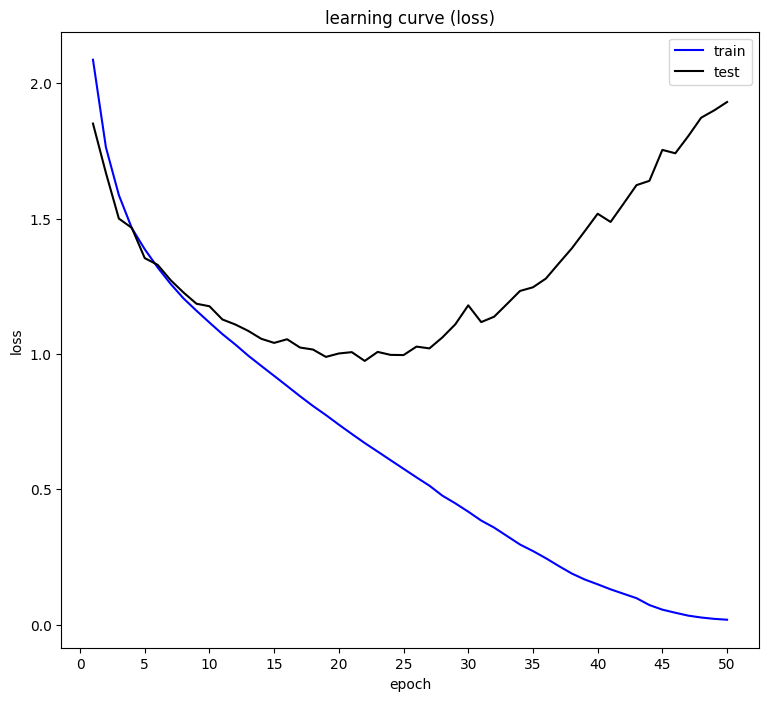

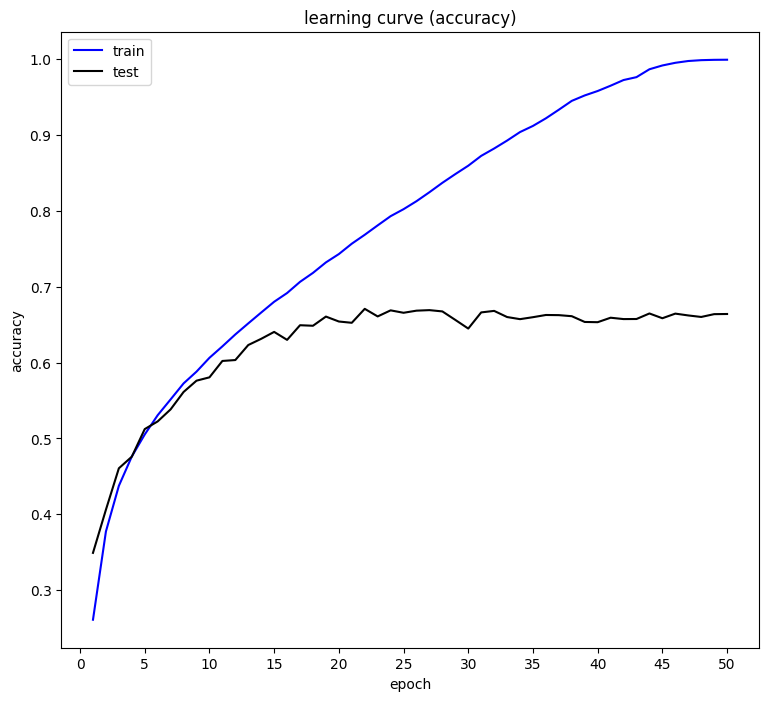

In [57]:
# 精度評価
utils.evaluated_history(history2)

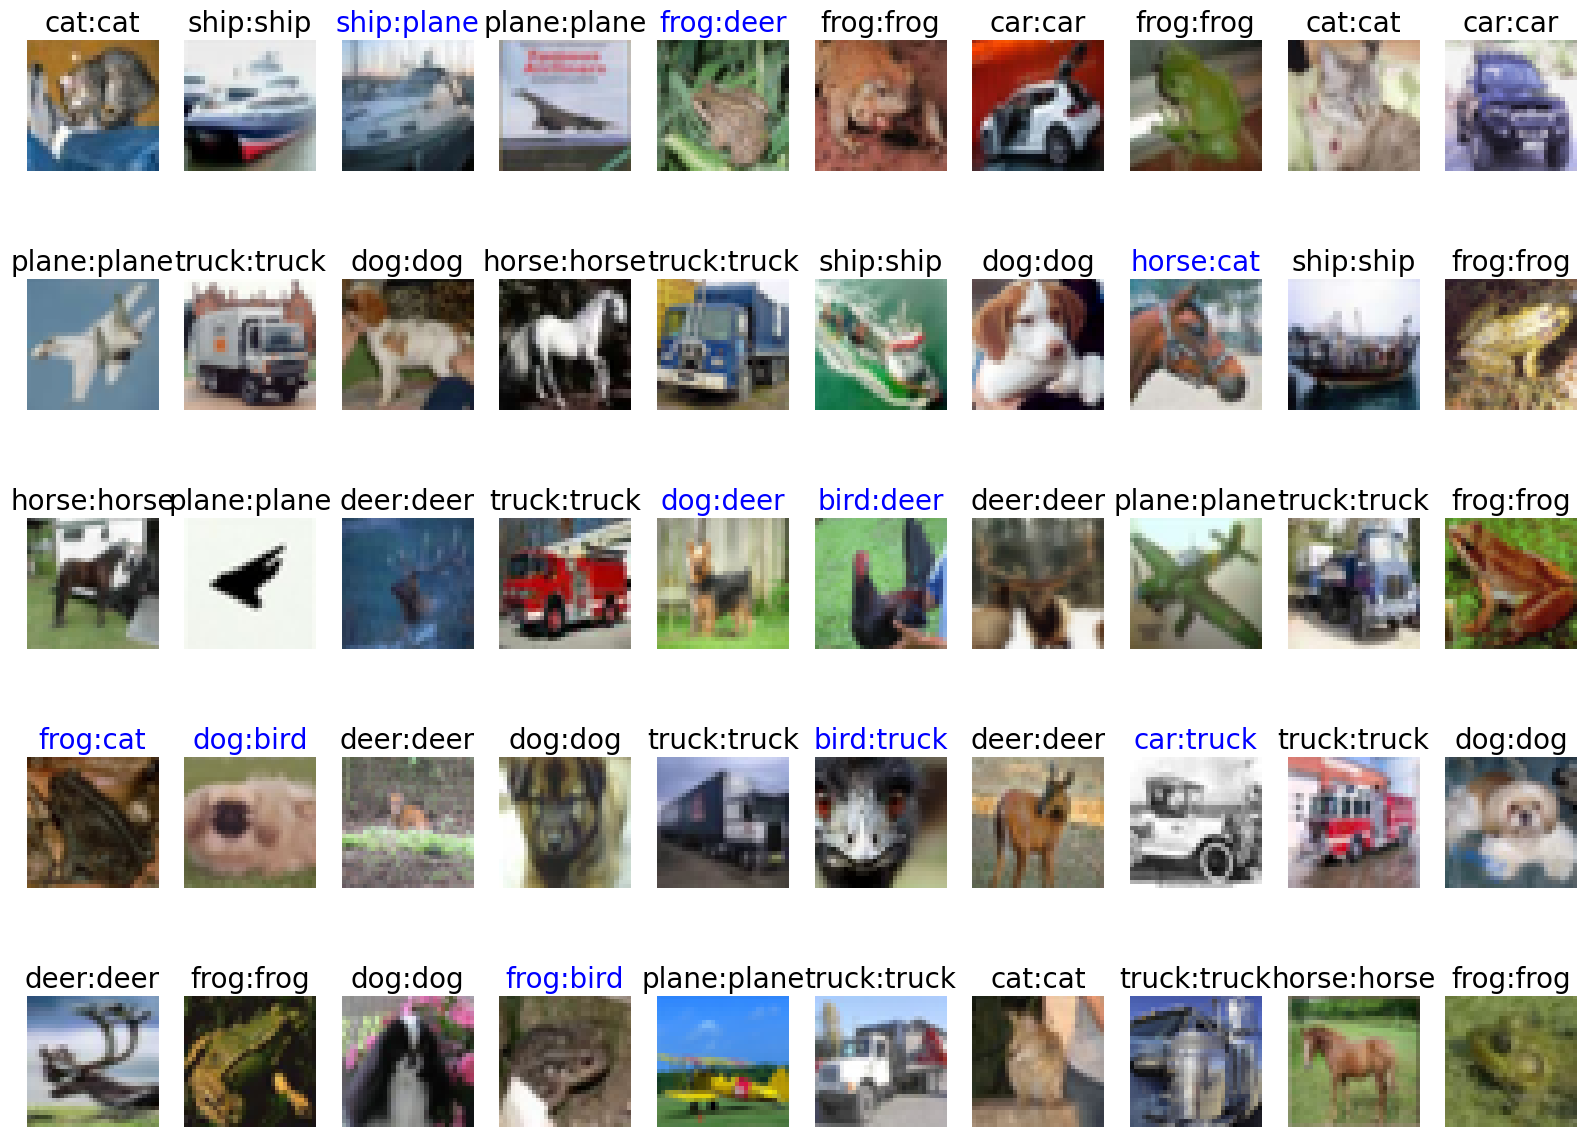

In [58]:
# 最初の50毎の画像の結果表示
utils.show_images_labels(test_loader2, classes, net, device)